# EE4211 Project

       Team 1: Quadratic                   Done by Choi Jae Hyung, Lee Min Young, Nicholas Lui Ming Yang, Tran Duy Anh

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from scipy import stats
from functools import reduce



In [2]:
df = pd.read_csv("project_data.csv")
# df.shape - (1584823, 3)
# df column values:
# localminute - Timestamp 
# dataid - MeterID 
# meter_value - meter reading

# Q1.1

# How many houses are included in the measurement study?

In [3]:
# Since dataid is unique for each meter, we can count the number of unique dataid numbers
df.dataid.value_counts().size

157

### This gives us 157 for the number of houses included in the study

# Are there any malfunctioning meters? If so, identify them and the time periods where they were malfunctioning.

## There are various ways to define a malfunctioning meter. Let us explore some of them

### Let us first check, if there are *meters that report a lower value at a later timestamp*. Since meter_value is cumulative consumption, meter_value should not be lower at a later timestamp for the same meter

In [4]:
grouped = df.groupby(['dataid'], sort=['localminute'])
def has_decreasing_values(df):
    current_value = 0
    for index, val in df.iteritems():
        if val < current_value:
            return True
        current_value = val
        
meters_with_decreasing = (grouped['meter_value']
                          .agg(has_decreasing_values)
                          .where(lambda x: x)
                          .dropna()
                          .keys())

In [5]:
print(len(meters_with_decreasing))
meters_with_decreasing

43


Int64Index([  35,   77,   94,  483,  484, 1042, 1086, 1185, 1507, 1556, 1718,
            1790, 1801, 2129, 2335, 2449, 3134, 3527, 3544, 3893, 4031, 4193,
            4514, 4998, 5129, 5131, 5193, 5403, 5810, 5814, 5892, 6836, 7017,
            7030, 7117, 7739, 7794, 7989, 8156, 8890, 9134, 9639, 9982],
           dtype='int64', name='dataid')

#### Wow, we have 43 meters that have a decreasing value! Let's zoom in and get the offending sections for each meter. (In other words, find the exact data points which show this descreasing value)

In [6]:
## Need to re-sort after filter since filter takes all rows and breaks original sorting
dec_meters = (grouped.filter(lambda x: int(x.name) in meters_with_decreasing)
              .groupby(['dataid'], sort=['localminute']))

## Iterate over values to find offending rows for each meter
## WARNING: RUNS VERY SLOWLY. TODO: OPTIMIZE
offending_values = {}
for group_id, rows in dec_meters.groups.items():
    offending_values[group_id] = []
    current_value = 0
    group_rows = dec_meters.get_group(group_id)
    group_rows_count = group_rows.shape[0]
    for i in range(group_rows_count):
        if group_rows.iloc[i]['meter_value'] < current_value:
            offending_values[group_id].append([group_rows.iloc[i-1], group_rows.iloc[i]])
        current_value = group_rows.iloc[i]['meter_value']
    

KeyboardInterrupt: 

##### Number of 'broken data' instances for each meter

In [ ]:
print("Meter ID |", "Number of broken readings")
for k, v in offending_values.items():
    print(str(k).ljust(20), len(v))
        

##### Just knowing the number of broken readings may not be useful. 
##### Let's say that we want to know which meters should be fixed, since faulty meters result in us inaccurately measuring consumption, and possibly losing money.
##### There should be some measure of tolerance in deciding if a meter is broken. In this case, let's check the average decreasing amount, and the ratio of "broken" readings 

In [ ]:
print("Meter ID |", "Number of broken readings |", "Average decrease across broken readings |", "Percentage of broken readings for meter")
for k, v in offending_values.items():
    print(str(k).ljust(20), 
          str(len(v)).ljust(20), 
          str(reduce(lambda x, y: x + abs(y[1]['meter_value'] - y[0]['meter_value']) / len(v), [0] + v )).ljust(40), 
          (len(v) / dec_meters.get_group(k).shape[0]) * 100)

#### With the data laid out like this, it is pretty clear that most meters are not really broken if we allow a 2% error rate
#### However, in terms of error volume, some are pretty suspect. Let's use an average volume error of 100 Cubic foot (that's a lot!) as our threshold, and filter our results

In [ ]:
print("Meter ID |", "Number of broken readings |", "Average decrease across broken readings |", "Percentage of broken readings for meter")
for k, v in offending_values.items():
    measure = str(reduce(lambda x, y: x + abs(y[1]['meter_value'] - y[0]['meter_value']) / len(v), [0] + v )).ljust(40)
    if float(measure) > 10:
        print(str(k).ljust(20), 
              str(len(v)).ljust(20), 
              measure, 
              (len(v) / dec_meters.get_group(k).shape[0]) * 100)

In [ ]:
"""Use this function to validate/check each bad meter given our heuristic"""
def print_bad_meter_readings(meterID):
    meter_readings = offending_values[meterID]
    print("time apart |".ljust(20), "meter value initial |", "meter value after |", "difference")
    for readings_pair in meter_readings:

        print(str(pd.to_datetime(readings_pair[1]['localminute']) - pd.to_datetime(readings_pair[0]['localminute'])).ljust(25), 
              str(readings_pair[0]['meter_value']).ljust(20), 
              str(readings_pair[1]['meter_value']).ljust(20), 
              readings_pair[1]['meter_value'] - readings_pair[0]['meter_value'])
print_bad_meter_readings(1556)
        

### Another requirement of the meters is that they push their readings to be saved if the meter values differ by at least 2 cubic foot
#### Let us verify that every pair of readings for a meter differ by at least 2 cubic foot. To not double count, we will only check for readings where the differing value is 0 >= x > 2 so that we don't get the same error readings where the readings decrease
#### Since the value is smaller, we will not focus on the difference in values, but on the percentage of total readings for the meter only

In [ ]:
grouped2 = df.groupby(['dataid'], sort=['localminute'])
def has_stagnant_values(df):
    current_value = 0
    for index, val in df.iteritems():
        if index == 0:
            current_value = val
            continue
        
        if val < current_value + 2 and val >= current_value:
            return True
        current_value = val
        
meters_with_stagnant = (grouped['meter_value']
                          .agg(has_stagnant_values)
                          .where(lambda x: x)
                          .dropna()
                          .keys())

print("Number of meters with stagnant values: ", len(meters_with_stagnant))

#### The following segment should have calculated the percentage of stagnant values for each meter, but it takes too long (tried for 5 minutes and gave up). At least we know number of meters that reported stagnant values?

In [ ]:
# ## Need to re-sort after filter since filter takes all rows and breaks original sorting
# stagnant_meters = (grouped2.filter(lambda x: int(x.name) in meters_with_stagnant)
#               .groupby(['dataid'], sort=['localminute']))

# ## Iterate over values to count offending occurences. Not counting value
# ## WARNING: RUNS VERY SLOWLY. TODO: OPTIMIZE
# offending_values2 = {}
# for group_id, rows in stagnant_meters.groups.items():
#     offending_values2[group_id] = 0
#     group_rows = stagnant_meters.get_group(group_id)
#     group_rows_count = group_rows.shape[0]
#     # Set current_value so we do not trigger first reading
#     current_value = group_rows.iloc[0]['meter_value'] - 5
#     for i in range(group_rows_count):
#         if group_rows.iloc[i]['meter_value'] < current_value + 2 and group_rows.iloc[i]['meter_value'] >= current_value:
#             offending_values2[group_id] += 1
#         current_value = group_rows.iloc[i]['meter_value']

        
# print("Meter ID |", "Number of broken readings |", "Percentage of broken readings for meter")
# for k, v in offending_values2.items():
#     print(str(k).ljust(20), 
#           str(v).ljust(20),  
#           (v / stagnant_meters.get_group(k).shape[0]) * 100)


In [ ]:
stagnant_meters = (grouped2.filter(lambda x: int(x.name) in meters_with_stagnant)
              .groupby(['dataid'], sort=['localminute']))

print("Total number of readings to iterate, which is why it is slow: ", 
      reduce(lambda x, y: x + len(y), [0] + list(stagnant_meters.groups.values())))

### We now have two different criterion for deciding what constitues a broken meter, and the readings that helped us determine that. Since the question asks for "time periods where they were malfunctioning.", let's demonstrate that we can consolidate broken readings into time periods

In [ ]:
# let's use the meter with the most broken readings (based off decreasing values)
most_broken_values_meter = grouped.get_group(5403)

In [ ]:
# We are using a stricter requirement now. Let's consider that, if the subsequent meter reading is less 
# than an increment of 2 (meters are only supposed to report after at least an increment of 2)

# Broken_criteria is a helper function (comparator function) that takes in two (in-order) readings and outputs a 
# boolean of whether the later reading is "broken"

broken_criteria = lambda x, y: y['meter_value'] < x['meter_value'] + 2

In [ ]:
broken_readings = 0
num_readings = most_broken_values_meter.shape[0]
for i in range(1, num_readings):
    if broken_criteria(most_broken_values_meter.iloc[i-1], most_broken_values_meter.iloc[i]):
        broken_readings += 1

print("Number of broken readings for meter 5403, based on stricter requirements: ", broken_readings)

In [ ]:
# Let's now create a function that can aggregate a meter's readings into "broken" time periods
# Return value of the function will be as follow:
"""
2D array. 
First dimension is the time periods. 
Second dimension is the consecutive broken readings that make up the broken time period
To find the actual time data, take the ['localminute'] attribute from the first and last reading per period
    time_periods = [
        [reading_1, reading_2, reading_3],
        [reading_1, reading_2]
    ]
"""
def get_broken_time_periods(broken_criteria, meter_readings):
    num_readings = meter_readings.shape[0]
    time_periods = []
    temp_period = []
    for i in range(1, num_readings):
        if broken_criteria(meter_readings.iloc[i-1], meter_readings.iloc[i]):
            temp_period.append(meter_readings.iloc[i])
        else:
            if temp_period:
                time_periods.append(temp_period)
                temp_period = []
    if temp_period:
        time_periods.append(temp_period)
    return time_periods

In [ ]:
broken_time_periods = get_broken_time_periods(broken_criteria, most_broken_values_meter)
print("Number of broken time periods: ", len(broken_time_periods))


# Q1.2 
## Hourly Data Collection and Plotting the Data

#### Objective: 
Obtain hourly data from a list of given data, and plot the obtained data

#### Parameters: 
#### 1. Gas meter ID 
Gas meter with ID 739 will be focused for the study
#### 2. Starting time
6th Oct 2015, 12 a.m.
#### 3. Ending time
5th Nov 2015, 11 p.m.

#### Assumption (How we aggregate the data into hourly readings)
- The data is always cumulative: increasing in value as time goes.

The lowest value in an hour should be the closest value to an exact hour (hh:00:00) and a good estimate of that hour's data.

Therefore, the first data point in an hour is used to represent the hourly data. (The assumption is that we are interested in approximating the consumption amount at the start of the hour)

#### How to handle missing data?
As the data is cumulative gas consumption by household, when there is no data, it can be assumed as there is insignificant gas consumption between that period.

Hence, the missing data will be given same value as most recent hourly data obtained.

#### Bad data readings
This plot of hourly readings does not account for "bad" data readings (consecutive reading with a lower value, which should not happen for cumulative consumption data)

The likelihood of seeing an hourly data point that is bad is Average P(bad readings an hour) * (4*60), since we have max 4 readings per minute

This reduces the code complexity to get a plot, and the usefulness of this approach depends on the usage of this plot

If we are simply looking for a general consumption level visualisation, then this plot should suffice. However, if we are looking for plots with a decrease in value to identify faulty meters, then this plot is insufficient. For that, we cannot hold our original assumption (that readings are cumulative and strictly increasing), and should take the MIN(hour_values) to represent that hour

## Code

#### The algorithm of hourly data collection consists of the functions below.

1. In every new hour, collect the lowest value as the hourly data.


2. Look out for missing hour. When missing hour is found, previuos hour data is given for that hour.


### Hourly Data Collection

#### Create DateHour column, that represents "Date + Hour" of the data.

In [3]:
#change to datetime format
df["localminute"] = pd.to_datetime(df["localminute"])
#get a dataframe of data by hour:
df_byhour = pd.DataFrame(df.groupby([df["localminute"].dt.date.rename("Date"), 
                               df["localminute"].dt.hour.rename("Hour"), 
                               df["dataid"]]).min().reset_index())

# To preview df_byhour sorted by meter and time
# df_byhour = df_byhour.sort_values=(by=['dataid', 'Date', 'Hour'])

#add a column called "DateHour" in the dataframe:
df_byhour['DateHour'] = pd.to_datetime(df_byhour['Date'].apply(str)+' '+df_byhour['Hour'].apply(str)+':00:00')


#### Choose the meter_ID, starting time and ending time of the hourly data collection.

In [ ]:
#Format: ID No.
ID = 739

#ranges from 06/10/2015 00:00:00 to 05/11/2015 23:00:00
start_date = datetime.date(2015, 10, 5)
end_date = datetime.date(2015, 11, 6)
filteredDF = df_byhour[(df_byhour["Date"] > start_date) & (df_byhour["Date"] < end_date)]

#### Collect hourly data.

In [ ]:
#from 06/10/2015 -> 06/11/2015 there are 31 days -> 744 data points
prevHr = pd.Timestamp('2015-10-06 00:00:00')
endHr = pd.Timestamp('2015-11-05 23:00:00')
#generate a temporary dataframe through get_group function with each id
dfTemp = filteredDF.groupby(['dataid']).get_group(ID)
#get the list of hours and meter values
hourList = dfTemp['DateHour'].tolist()
valList = dfTemp['meter_value'].tolist()
#re-initialize the prev val as the first value of the val list
prevVal = valList[0]
#re-initialize the list of values as a list with 1 item
newList = [valList[0]]
#loop through each hour in the list
for index, hr in enumerate(hourList):
    #if hour is more than an hour bigger than previous
    while (hr - prevHr).seconds >= 3600:
        newList.append(prevVal)
        #increment every hour
        prevHr += pd.Timedelta(seconds=3600)
        
    #update the prev value everytime one index is passed
    prevVal = valList[index]
    
#some data does not reach until the end date, thats where this comes in
while prevHr < endHr:
    newList.append(prevVal)
    #increment every hour
    prevHr += pd.Timedelta(seconds=3600)
    

### Plot the hourly reading.

In [ ]:
x = pd.date_range(datetime.date(2015, 10, 6), datetime.date(2015, 11, 6), freq = 'H').tolist()
#get rid of the last hour which is 00:00:00 06/11/2016
x.pop()
y = newList

fig, ax = plt.subplots(1, 1, figsize=(20, 6))
ax.plot(x, y, 'ok', ms=1)
plt.xlabel ("Time")
plt.ylabel ("Meter value")
ax.set_title('Hourly Data')
plt.show()

## Q1.3 Find for each home, 5 houses with highest correlation

#### Uses Numpy.corrcoeff to get Pearson product-moment correlation coefficients

In [4]:
#get a list of meter id
idList = df['dataid'].unique()

df["localminute"] = pd.to_datetime(df["localminute"])
#get a dataframe of data by hour:
df_byhour = pd.DataFrame(df.groupby([df["localminute"].dt.date.rename("Date"), 
                               df["localminute"].dt.hour.rename("Hour"), 
                               df["dataid"]]).mean().reset_index())

#add a column called "DateHour" in the dataframe:
df_byhour['DateHour'] = pd.to_datetime(df_byhour['Date'].apply(str)+' '+df_byhour['Hour'].apply(str)+':00:00')

In [5]:
#there are 183 days => 4392 hours => 4392 readings in each list
#generate a dictionary
hourlyDataDict = {}

#define start hour and end hour
staHr = pd.Timestamp('2015-10-01 05:00:00')
endHr = pd.Timestamp('2016-04-01 04:00:00')

#loop through each id 
for id1 in idList:
    
    #re-innitialize the prev Hour as start hour
    prevHr = staHr
    #generate a temporary dataframe through get_group function with each id
    dfTemp = df_byhour.groupby(['dataid']).get_group(id1)
    #get the list of hours and meter values
    hourList = dfTemp['DateHour'].tolist()
    valList = dfTemp['meter_value'].tolist()
    #re-initialize the prev pal as the first value of the val list
    prevVal = valList[0]
    #re-initialize the list of values as a list with 1 item
    newList = [valList[0]]
    #loop through each hour in the list
    for index, hr in enumerate(hourList):
        #if hour is more than an hour bigger than previous
        while (hr - prevHr).seconds >= 3600:
            newList.append(prevVal)
            #increment every hour
            prevHr += pd.Timedelta(seconds=3600)
        
        #update the prev value everytime one index is passed
        prevVal = valList[index]
    
    #some data does not reach until the end date, thats where this comes in
    while prevHr < endHr:
        newList.append(prevVal)
        #increment every hour
        prevHr += pd.Timedelta(seconds=3600)
    
    #after all that create a new entry in the Dictionary with the key as the id and value is the list of meter readings
    hourlyDataDict[id1] = newList



Creating a Dictionary of Correlation Coefficient

In [ ]:
corDict = {}
#loop through id List to get the first id
for id1 in idList:
    #create the empty value for the first key
    corDict[id1] = {}
    #loop through the id list to get the second id
    for id2 in idList:
        # generate the coefficient through numpy.corrcoef (can be changed later)
        coef = np.corrcoef(hourlyDataDict[id1], hourlyDataDict[id2])[0, 1]
        # assign the value to the dict with the appropriate key
        corDict[id1][id2] = coef
        #print("coefficient between " + str(id1) + " and " + str(id2) + " is: " + str(coef))

### Now, let's find the top 5 houses with highest correlation value for each house 

In [ ]:
from collections import Counter

idList.sort()
top5dict = {}

for id in idList:
    
    #### This is if you just want the houseID for each (first column being the ID)
    
#     print(sorted(corDict[id], key =corDict[id].get, reverse=True)[:6])
    
    #### This is if you want to get the houseID + the value of correlation coefficient
    c = Counter(corDict[id])
    mc = c.most_common(6)
    del mc[0]
    
    top5dict.update({id : mc})
    
top5dict

# 2.1 In this part, you will asked to build a model to forecast the hourly readings in the future (next hour). Can you explain why you may want to forecast the gas consumption in the future

Predicting gas consumption in the future is necessary because of many reasons:
1. Gas is a natural resource and it is limited, predicting gas consumption will shed some light onto how much more we need to produce and when it is necessary to cut down on the consumption for fear of exhausting this natural resource.
2. Future gas consumption will also help people manage their finances better
3. 

## Who would find this information valuable?

Just to list down a few: customers, government, environmental activists, gas company, maintenance company

##  What can you do if you have a good forecasting model?

Sell it

##  Build a linear regression model to forecast the hourly readings in the future (next hour)

### Import machine learning libraries

In [6]:
import sklearn
from sklearn.linear_model import LinearRegression as LR

In [7]:
#hourArray = features_train = np.asarray(range(4392)).reshape(-1,1)
clfDict = {}
for key in hourlyDataDict:
    #each key is a linear regression model
    clfDict[key] =  LR()
    #features_train = the number of hour from 5:00:00 01/10/2015
    features_train = hourArray
    
    #print(features_train)
    #labels_train = values
    labels_train = np.asarray(hourlyDataDict[key])
    
    #fit the model accordingly
    clfDict[key].fit(features_train, labels_train)

#### When you want to do linear prediction use

In [76]:
#: clfDict['meter_id']([['numberofhours']])
# #clfDict[739].predict([[3333]])
# since the Prediction is very dogshit, we make a new Prediction function

#define the start time as a timestamp format
staHr = pd.Timestamp('2015-10-01 05:00:00')


dtStar = datetime.date(2015, 10, 1) + datetime.timedelta(hours=5)
dtEnd = datetime.date(2016, 4, 1) + datetime.timedelta(hours=4)
#get a list of dateTime from the start to the end
dateTimeList = pd.date_range(dtStar, dtEnd, freq = 'H').tolist()

hourList = [[((x - staHr).seconds + (x - staHr).days*86400)/ 3600] for x in dateTimeList]

def newPred(meter_id):
    return clfDict[meter_id].predict(hourList)
hourList


[[-5.0],
 [-4.0],
 [-3.0],
 [-2.0],
 [-1.0],
 [0.0],
 [1.0],
 [2.0],
 [3.0],
 [4.0],
 [5.0],
 [6.0],
 [7.0],
 [8.0],
 [9.0],
 [10.0],
 [11.0],
 [12.0],
 [13.0],
 [14.0],
 [15.0],
 [16.0],
 [17.0],
 [18.0],
 [19.0],
 [20.0],
 [21.0],
 [22.0],
 [23.0],
 [24.0],
 [25.0],
 [26.0],
 [27.0],
 [28.0],
 [29.0],
 [30.0],
 [31.0],
 [32.0],
 [33.0],
 [34.0],
 [35.0],
 [36.0],
 [37.0],
 [38.0],
 [39.0],
 [40.0],
 [41.0],
 [42.0],
 [43.0],
 [44.0],
 [45.0],
 [46.0],
 [47.0],
 [48.0],
 [49.0],
 [50.0],
 [51.0],
 [52.0],
 [53.0],
 [54.0],
 [55.0],
 [56.0],
 [57.0],
 [58.0],
 [59.0],
 [60.0],
 [61.0],
 [62.0],
 [63.0],
 [64.0],
 [65.0],
 [66.0],
 [67.0],
 [68.0],
 [69.0],
 [70.0],
 [71.0],
 [72.0],
 [73.0],
 [74.0],
 [75.0],
 [76.0],
 [77.0],
 [78.0],
 [79.0],
 [80.0],
 [81.0],
 [82.0],
 [83.0],
 [84.0],
 [85.0],
 [86.0],
 [87.0],
 [88.0],
 [89.0],
 [90.0],
 [91.0],
 [92.0],
 [93.0],
 [94.0],
 [95.0],
 [96.0],
 [97.0],
 [98.0],
 [99.0],
 [100.0],
 [101.0],
 [102.0],
 [103.0],
 [104.0],
 [105.0],
 [106

ValueError: x and y must have same first dimension, but have shapes (4393,) and (4392,)

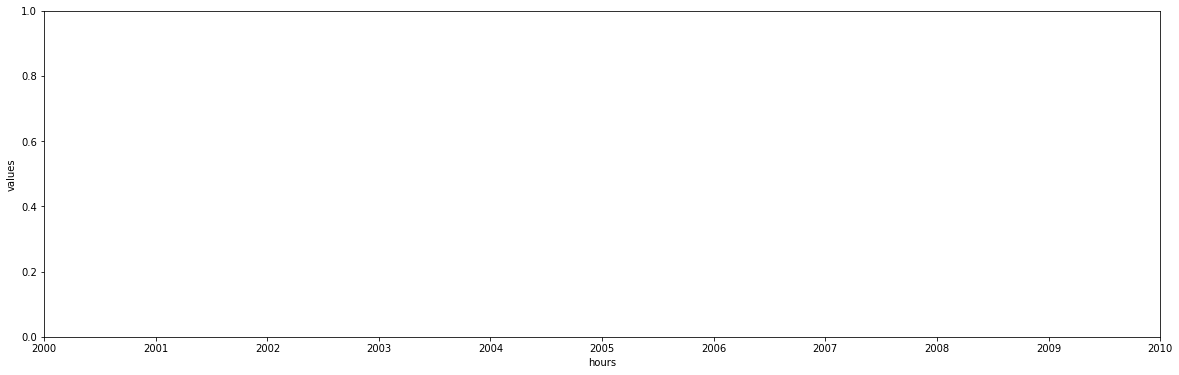

In [60]:
for key in clfDict:
    #fig = plt.figure()
    fig, ax = plt.subplots(1, 1, figsize=(20, 6))
    
    plt.xlabel('hours')
    plt.ylabel('values')
    x = dateTimeList
    y = np.asarray(hourlyDataDict[key])
    #ax.scatter(x, y,color='g')
    ax.plot(x, y,color='g')
    ax.plot(x,  newPred(key) ,color='k')
    plt.title("Linear Regression Plot " + str(key))

    plt.show()